# Creating a Test Dataset for FunkSVD Evaluation
Evaluating SVD type models can be challenging because they are unsupervised. However, when used in recommendation engines, we can connect the outputs to target values and measure performance, effectively evaluating unsupervised training through a supervised outcome.

In this notebook, we'll create a test set for the FunkSVD model using held-out movie ratings. First, we'll use the reviews data to create a user-by-movie matrix. Then, we'll use this matrix to create training and test sets. The training set will be used to train the FunkSVD model, and we'll make predictions to evaluate the model with our held-out test set. By trying different numbers of latent features, we'll see how this choice affects model performance.




## Setup and Load Data

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
# Load the reviews_clean.csv dataset
reviews_df = pd.read_csv("reviews_clean.csv")
print("Data dimensions:", reviews_df.shape)

Data dimensions: (100001, 5)


In [4]:
reviews_df.head()

,user_id,movie_id,rating,timestamp,date
0,1,114508,8,1381006850,2013-10-05 14:00:50
1,2,208092,5,1586466072,2020-04-09 14:01:12
2,2,358273,9,1579057827,2020-01-14 19:10:27
3,2,10039344,5,1578603053,2020-01-09 12:50:53
4,2,6751668,9,1578955697,2020-01-13 14:48:17


## Create the FunkSVD Function
This is created for you, which you'll notice is very similar to the function you created in the previous lessons. The main difference is that this function will output the mean squared error for the training set if you set the output_mse to True. It also returns a list of mean squared errors at each iteration so we can plot them.

In [5]:
def FunkSVD(
    ratings_mat, latent_features=4, learning_rate=0.0001, iters=100, output_mse=False
):
    """
    This function performs matrix factorization using a basic form of FunkSVD with no regularization

    INPUT:
    ratings_mat - (numpy array) a matrix with users as rows, movies as columns, and ratings as values
    latent_features - (int) the number of latent features used
    learning_rate - (float) the learning rate
    iters - (int) the number of iterations

    OUTPUT:
    user_mat - (numpy array) a user by latent feature matrix
    movie_mat - (numpy array) a latent feature by movie matrix
    mse_scores - (list) list of mean squared errors at each iteration
    """

    # Set up useful values to be used through the rest of the function
    n_users = ratings_mat.shape[0]
    n_movies = ratings_mat.shape[1]
    num_ratings = np.count_nonzero(~np.isnan(ratings_mat))
    mse_scores = []

    # initialize the user and movie matrices with random values
    user_mat = np.random.rand(n_users, latent_features)
    movie_mat = np.random.rand(latent_features, n_movies)

    # initialize sse at 0 for first iteration
    sse_accum = 0

    if output_mse:
        # keep track of iteration and MSE
        print("Optimization Statistics")
        print("Iterations | Mean Squared Error ")

    # for each iteration
    for iteration in range(iters):

        # update our sse
        old_sse = sse_accum
        sse_accum = 0

        # For each user-movie pair
        for i in range(n_users):
            for j in range(n_movies):

                # if the rating exists
                if ratings_mat[i, j] > 0:

                    # compute the error as the actual minus the dot product of the user and movie latent features
                    diff = ratings_mat[i, j] - np.dot(user_mat[i, :], movie_mat[:, j])

                    # Keep track of the sum of squared errors for the matrix
                    sse_accum += diff**2

                    # update the values in each matrix in the direction of the gradient
                    for k in range(latent_features):
                        user_mat[i, k] += learning_rate * (2 * diff * movie_mat[k, j])
                        movie_mat[k, j] += learning_rate * (2 * diff * user_mat[i, k])
        mse = sse_accum / num_ratings
        mse_scores.append(mse)
        # print results
        if output_mse:
            print("%d \t\t %f" % (iteration + 1, mse))

    return user_mat, movie_mat, mse_scores

## Create User-By-Movie Matrix

In [6]:
# Create a user_items subset and a user-by-item matrix
# User items subset should container user_id, movie_id, rating, and timestamp
user_items = reviews_df[["user_id", "movie_id", "rating", "timestamp"]]
# Create the user by movie matrix by grouping the user items by user_id and movie_id and getting the maximum rating
user_by_movie = user_items.groupby(["user_id", "movie_id"])["rating"].max().unstack()

In [7]:
# Assign the number of unique users and movies
n_users = user_by_movie.shape[0]
n_movies = user_by_movie.shape[1]
print(f"Number of users: {n_users}")
print(f"Number of movies: {n_movies}")

Number of users: 8022
Number of movies: 13850


In [8]:
# Running FunkSVD on this large dataset is computationally expensive. Let's just keep the top 1000 most rated movies.
# Truncate the user by movie matrix to only include the top 1000 most rated movies
top_movies = user_by_movie.count().sort_values(ascending=False).index[:1000]
user_by_movie = user_by_movie.loc[:, top_movies]

In [9]:
# Drop users that have not seen any movies, we're not trying to solve for them
# You can do this by filtering the user by movie matrix to only include users that have rated more than 0 movies
user_by_movie = user_by_movie.loc[user_by_movie.sum(axis=1) > 0]

In [10]:
print(f"Final number of users: {user_by_movie.shape[0]}")
print(f"Final number of movies: {user_by_movie.shape[1]}")

Final number of users: 6645
Final number of movies: 1000


In [11]:
# Look at the first few rows and columns of the matrix, it's very sparse
user_by_movie.head()

movie_id,1454468,8579674,993846,7286456,816692,770828,1300854,1535109,1670345,816711,...,1217209,1596343,45152,10431500,2378281,1666801,118749,1385826,2771372,82971
user_id,,,,,,,,,,,,,,,,,,,,,
2,NaN,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,8.0,NaN,NaN,NaN,NaN,NaN


In [12]:
# Run the FunkSVD function on the user by movie matrix, with 5 latent features, 0.001 learning rate, and 25 iterations
# Don't forget to convert the user_by_movie matrix to a numpy array for the FunkSVD function using this np.matrix() function
user_mat, movie_mat, mse_scores = FunkSVD(
    np.matrix(user_by_movie),
    latent_features=5,
    learning_rate=0.001,
    iters=25,
    output_mse=True,
)

Optimization Statistics
Iterations | Mean Squared Error 
1 		 26.945235
2 		 11.620231
3 		 7.601005
4 		 5.698300
5 		 4.627466
6 		 3.949752
7 		 3.486262
8 		 3.151579
9 		 2.899810
10 		 2.704176
11 		 2.548097
12 		 2.420820
13 		 2.315115
14 		 2.225956
15 		 2.149759
16 		 2.083900
17 		 2.026416
18 		 1.975810
19 		 1.930917
20 		 1.890821
21 		 1.854788
22 		 1.822221
23 		 1.792633
24 		 1.765619
25 		 1.740842


Text(0.5, 1.0, 'Mean Squared Error vs. Iterations')

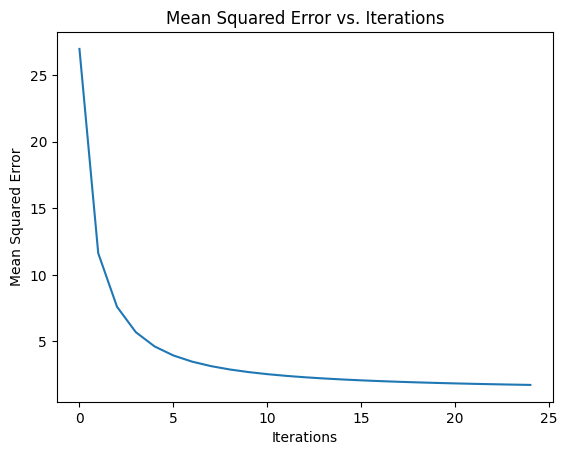

In [13]:
# Plot mse scores
plt.plot(mse_scores)
plt.xlabel("Iterations")
plt.ylabel("Mean Squared Error")
plt.title("Mean Squared Error vs. Iterations")

In [14]:
# Let's take a look at the user_mat and movie_mat matrices
pred_user_by_movie = np.dot(user_mat, movie_mat)
pred_user_by_movie[:5, :5]

array([[ 8.05430055,  8.74313716,  8.2171867 ,  9.0950287 ,  8.68193006],
       [ 7.86756621,  8.75485882,  8.03206237,  8.98292219,  8.5972691 ],
       [ 9.34849872, 10.53672097,  9.4464405 , 10.37195372, 10.11993846],
       [ 8.6798908 ,  8.68001494,  8.54716224,  9.17571862,  9.0368433 ],
       [ 8.88745766,  9.91482209,  9.25989879, 10.49752112,  9.65065352]])

## Create Train and Test Sets
It's now time to create our train set and hold out test set. To create our hypothetical test set, we will take a subset of users that have seen many movies, randomly select a few movies per user, and set them aside to be in our test set. The remaining movies per user will be our training set. Think of this as a simulation of a scenario where we have users that have rated many movies, and we want to see how well we can predict their ratings on a few additional movies. 

In [15]:
# Create a subset of the reviews data that only include the movies and users in the user by movie matrix. Remember we only selected the top 1000 movies.
# Find the movies from reviews_df that are in the user by movie matrix
sub_movies = reviews_df.movie_id.isin(user_by_movie.columns)
# Find the users from reviews_df that are in the user by movie matrix
sub_users = reviews_df.user_id.isin(user_by_movie.index)
sub_reviews_df = reviews_df[sub_movies & sub_users]
# Size of the subset
print(f"Size of the subset: {sub_reviews_df.shape}")

Size of the subset: (60384, 5)


In [16]:
# Select users that have rated more than 5 movies, as we'll hold out a few of them but still want to train on the rest
# Find the value counts of user_id in the subset
user_counts = sub_reviews_df.user_id.value_counts()
users_with_enough_ratings = user_counts[user_counts > 5].index.tolist()
print(f"Number of users with more than 5 ratings: {len(users_with_enough_ratings)}")

Number of users with more than 5 ratings: 1838


In [17]:
# Create a test set by randomly selecting 2 movies per user to include in our test set
test = (
    sub_reviews_df[sub_reviews_df.user_id.isin(users_with_enough_ratings)]
    .groupby("user_id")
    .sample(2, random_state=42)
)

# Now that we have test set, we can create the train set by dropping the test indices from the sub_reviews_df
train = sub_reviews_df.drop(test.index)
print(f"Train set size: {train.shape}")
print(f"Test set size: {test.shape}")

Train set size: (56708, 5)
Test set size: (3676, 5)


In [18]:
# Create a user by movie matrix for the train set using the same column names as the user by movie matrix above
train_user_items = train[["user_id", "movie_id", "rating", "timestamp"]]
train_user_by_movie = (
    train_user_items.groupby(["user_id", "movie_id"])["rating"].max().unstack()
)
print(f"Train number of users: {train_user_by_movie.shape[0]}")
print(f"Train number of movies: {train_user_by_movie.shape[1]}")
print(f"Dimensions of train_user_by_movie: {train_user_by_movie.shape}")

Train number of users: 6645
Train number of movies: 1000
Dimensions of train_user_by_movie: (6645, 1000)


In [19]:
# Create a user by movie matrix for the test set using the same column names as the entire user by movie matrix above
test_user_items = test[["user_id", "movie_id", "rating", "timestamp"]]
test_user_by_movie = (
    test_user_items.groupby(["user_id", "movie_id"])["rating"].max().unstack()
)
print(f"Test number of users: {test_user_by_movie.shape[0]}")
print(f"Test number of movies: {test_user_by_movie.shape[1]}")
print(f"Dimensions of test_user_by_movie: {test_user_by_movie.shape}")

Test number of users: 1838
Test number of movies: 867
Dimensions of test_user_by_movie: (1838, 867)


In [20]:
# Oops we have a problem, our train and test user_by_movie matrices have different dimensions.
# Let's make sure that the test_user_by_movie matrix has the same dimensions as the user_by_movie matrix
# Reindex the test_user_by_movie matrix with the index and columns of the train_user_by_movie matrix
# We will fill the missing values with NaN by default
test_user_by_movie = test_user_by_movie.reindex(
    index=train_user_by_movie.index, columns=train_user_by_movie.columns
)
print(f"Updated dimensions of test_user_by_movie: {test_user_by_movie.shape}")

Updated dimensions of test_user_by_movie: (6645, 1000)


### Why did we make sure to sample users with more than 5 ratings? What would happen if we ended up setting aside all of the movies for a user in the test set?

We need some data to train on, so we need to make sure that we have some movies left for each user in the training set. If we set aside all the movies for a user in the test set, we would have no data to train on for that user, and we wouldn't be able to make predictions for them. This would result in a cold start problem, and could not be used for evaluation.

In [21]:
# Let's train the FunkSVD model on the train_user_by_movie matrix with 2 latent features, 0.001 learning rate, and 10 iterations
user_train_mat, movie_train_mat, mse_train_scores = FunkSVD(
    np.matrix(train_user_by_movie), latent_features=2, learning_rate=0.001, iters=10
)

Text(0.5, 1.0, 'Train - Mean Squared Error vs. Iterations')

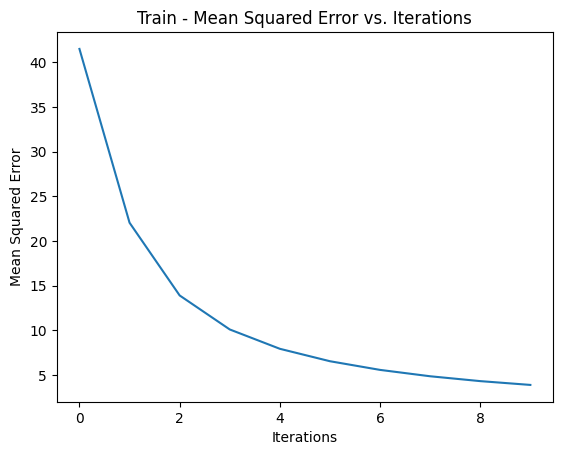

In [22]:
# Plot mse scores for the train set to see how well the model performed
plt.plot(mse_train_scores)
plt.xlabel("Iterations")
plt.ylabel("Mean Squared Error")
plt.title("Train - Mean Squared Error vs. Iterations")

In [24]:
# In order to compare the predicted values with the actual values in the test set, we need to know which values to look at.
# Index the nonnull values from test_user_by_movie so we can compare with the predictions
# We create a mask of the nonnull values in the test_user_by_movie matrix
user_item_test_mask = ~np.isnan(test_user_by_movie.values.flatten())
# Select the nonnull values from the test_user_by_movie matrix using the mask. Flatten the matrix to 1D and apply the mask
test_user_by_movie_values = test_user_by_movie.values.flatten()[user_item_test_mask]

In [25]:
# Make predictions for the test set by taking the dot product of the user and movie train matrices
test_predictions = np.dot(user_train_mat, movie_train_mat)

# Use the user_item_test_mask to select the same values from the predictions
test_predictions_values = test_predictions.flatten()[user_item_test_mask]

# Calculate mse for the test set using the actual and predicted values
test_mse = np.mean((test_user_by_movie_values - test_predictions_values) ** 2)
print(f"Test MSE: {test_mse}")

Test MSE: 3.1727293891545796


In [26]:
# Not bad, but let's see how the model performs with different number of latent features
# We will calculate the mse for the test set for different number of latent features, from 1 to 25, with a step of 3
# Use FunkSVD to train the model per number of latent feature, with a learning rate of 0.001 and 5 iterations
# Store the mse in a list so we can plot it
mse_per_latent = []
for i in range(1, 25, 3):
    user_train_mat, movie_train_mat, mse_train_scores = FunkSVD(
        np.matrix(train_user_by_movie), latent_features=i, learning_rate=0.001, iters=5
    )
    test_predictions = np.dot(user_train_mat, movie_train_mat)
    test_predictions_values = test_predictions.flatten()[user_item_test_mask]
    test_mse = np.mean((test_user_by_movie_values - test_predictions_values) ** 2)
    mse_per_latent.append(test_mse)
    print(f"Test MSE for {i} latent features: {test_mse}")

Test MSE for 1 latent features: 10.713087503358055
Test MSE for 4 latent features: 5.879038724151001
Test MSE for 7 latent features: 4.0695194997191235
Test MSE for 10 latent features: 3.4879821623963947
Test MSE for 13 latent features: 3.002959778564156
Test MSE for 16 latent features: 2.820317362323821
Test MSE for 19 latent features: 2.5564022695957074
Test MSE for 22 latent features: 2.531283967600401


Text(0.5, 1.0, 'Mean Squared Error vs. Latent Features')

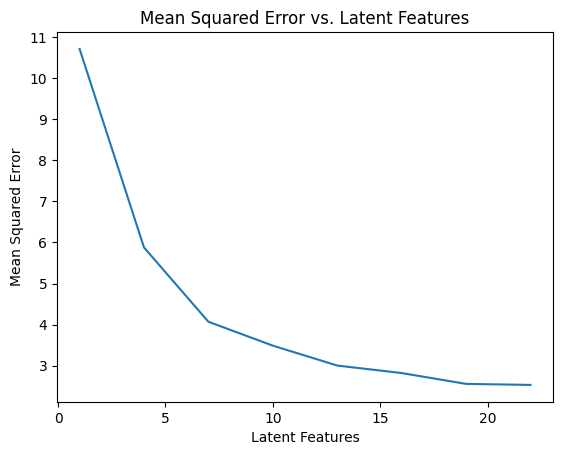

In [27]:
# plot mse per latent features
plt.plot(range(1, 25, 3), mse_per_latent)
plt.xlabel("Latent Features")
plt.ylabel("Mean Squared Error")
plt.title("Mean Squared Error vs. Latent Features")

In [32]:
# Take a look at the first 10 actual and predicted values. How do they compare?
pd.DataFrame(
    {
        "actual": test_user_by_movie_values[:10],
        "predicted": test_predictions_values[:10].round(1),
    }
)

,actual,predicted
0,9.0,7.7
1,10.0,10.9
2,8.0,7.0
3,9.0,8.4
4,9.0,7.9
5,7.0,8.4
6,8.0,7.7
7,7.0,6.7
8,9.0,8.7
9,6.0,8.1
